<h1 align='center' style='color:purple'>HR Analytics - Predict the Promotion</h1>

<h3 align='left' style='color:blue'>Sinivasa V</h3>

In [1]:
# Import t

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling as pp

import seaborn as sns

#Metrices
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics


In [2]:

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
train = pd.read_csv('train.csv')

test = pd.read_csv('test.csv')


In [4]:
print(train.head())

print(test.head())

   employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1            0                  49   
1 

In [5]:
train.columns,test.columns

(Index(['employee_id', 'department', 'region', 'education', 'gender',
        'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
        'length_of_service', 'KPIs_met >80%', 'awards_won?',
        'avg_training_score', 'is_promoted'],
       dtype='object'),
 Index(['employee_id', 'department', 'region', 'education', 'gender',
        'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
        'length_of_service', 'KPIs_met >80%', 'awards_won?',
        'avg_training_score'],
       dtype='object'))

In [6]:
train.rename(columns={'KPIs_met >80%':'KPIs',
                          'awards_won?':'awards_won'},inplace=True)

test.rename(columns={'KPIs_met >80%':'KPIs',
                          'awards_won?':'awards_won'},inplace=True)

In [7]:
train.info(), test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54808 non-null int64
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs                    54808 non-null int64
awards_won              54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
employee_id             23490 non-null int64
department              23490 non-null

(None, None)

In [8]:
train.nunique(), test.nunique()

(employee_id             54808
 department                  9
 region                     34
 education                   3
 gender                      2
 recruitment_channel         3
 no_of_trainings            10
 age                        41
 previous_year_rating        5
 length_of_service          35
 KPIs                        2
 awards_won                  2
 avg_training_score         61
 is_promoted                 2
 dtype: int64, employee_id             23490
 department                  9
 region                     34
 education                   3
 gender                      2
 recruitment_channel         3
 no_of_trainings             9
 age                        41
 previous_year_rating        5
 length_of_service          34
 KPIs                        2
 awards_won                  2
 avg_training_score         61
 dtype: int64)

In [9]:
train.isnull().sum(),
test.isnull().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs                       0
awards_won                 0
avg_training_score         0
dtype: int64

In [10]:
#train['education']=train.education.fillna().mean()
train['education'] = train['education'].fillna(train['education'].mode()[0])
train['previous_year_rating'] = train['previous_year_rating'].fillna(train['previous_year_rating'].mode()[0])

In [11]:
#df['education']=df.education.fillna().mean()
test['education'] = test['education'].fillna(test['education'].mode()[0])
test['previous_year_rating'] = test['previous_year_rating'].fillna(test['previous_year_rating'].mode()[0])

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54808 non-null int64
department              54808 non-null object
region                  54808 non-null object
education               54808 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    54808 non-null float64
length_of_service       54808 non-null int64
KPIs                    54808 non-null int64
awards_won              54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [13]:
train.describe(include ='all')

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs,awards_won,avg_training_score,is_promoted
count,54808.000000,54808,54808,54808,54808,54808,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
unique,NaN,9,34,3,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Sales & Marketing,region_2,Bachelor's,m,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,16840,12343,39078,38496,30446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,39195.830627,NaN,NaN,NaN,NaN,NaN,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,NaN,NaN,NaN,NaN,NaN,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,NaN,NaN,NaN,NaN,NaN,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,NaN,NaN,NaN,NaN,NaN,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,NaN,NaN,NaN,NaN,NaN,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000


In [14]:
train['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [15]:
# Drop the Unique ID and region and in test data we can keep id for future prediction

train = train.drop(['employee_id','region'], axis=1)

test = test.drop(['region'], axis=1)

In [16]:
#seperating numerical and categorical features

cat_train = train.select_dtypes(include=['object'])
num_train = train.select_dtypes(exclude=['object'])

In [17]:
#seperating numerical and categorical features

cat_test = test.select_dtypes(include=['object'])
num_test = test.select_dtypes(exclude=['object'])

In [18]:
# Import the LabelEncoder 

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cat_train.dtypes

department             object
education              object
gender                 object
recruitment_channel    object
dtype: object

In [19]:
# Convert the Categories to Numeric on train Data

cat_train['department']=le.fit_transform(cat_train['department'])
cat_train['education']=le.fit_transform(cat_train['education'])
cat_train['gender']=le.fit_transform(cat_train['gender'])
cat_train['recruitment_channel']=le.fit_transform(cat_train['recruitment_channel'])


cat_train.head()

,department,education,gender,recruitment_channel
0,7,2,0,2
1,4,0,1,0
2,7,0,1,2
3,7,0,1,0
4,8,0,1,0


In [20]:
# Convert the Categories to Numeric on test Data

cat_test['department']=le.fit_transform(cat_test['department'])
cat_test['education']=le.fit_transform(cat_test['education'])
cat_test['gender']=le.fit_transform(cat_test['gender'])
cat_test['recruitment_channel']=le.fit_transform(cat_test['recruitment_channel'])


cat_test.head()

,department,education,gender,recruitment_channel
0,8,0,1,2
1,2,0,0,0
2,7,0,1,0
3,5,0,0,0
4,1,0,1,2


In [21]:
# skewness along the index axis 

num_train.skew(axis = 0, skipna = True) 

no_of_trainings         3.445434
age                     1.007432
previous_year_rating   -0.260858
length_of_service       1.738061
KPIs                    0.619909
awards_won              6.338914
avg_training_score      0.451908
is_promoted             2.972339
dtype: float64

In [22]:
# Describe the stats of the Train Data

num_train.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs,awards_won,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170
std,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


Mean:  5.865512333965844 
Median:  5.0 
Mode:  3


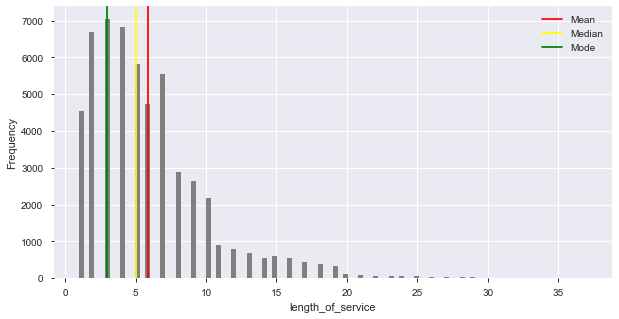

In [23]:
# Check and Visualisation of Skewness of the Data length_of_service

length_of_service = num_train['length_of_service']

mean=length_of_service.mean()
median=length_of_service.median()
mode=length_of_service.mode()

print('Mean: ',mean,'\nMedian: ',median,'\nMode: ',mode[0])

plt.figure(figsize=(10,5))
plt.hist(length_of_service,bins=100,color='grey')
plt.axvline(mean,color='red',label='Mean')
plt.axvline(median,color='yellow',label='Median')
plt.axvline(mode[0],color='green',label='Mode')
plt.xlabel('length_of_service')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Mean:  63.38675010947307 
Median:  60.0 
Mode:  50


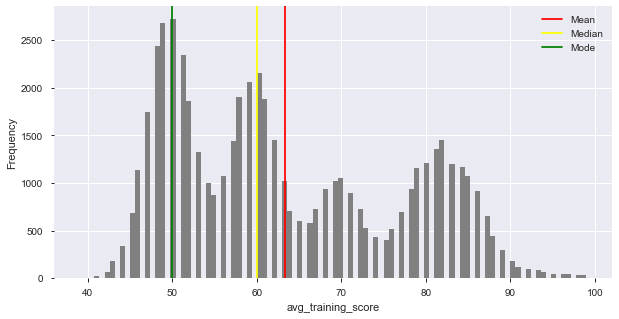

In [24]:
# Check and Visualisation of Skewness of the Data of the avg_training_score

avg_training_score = num_train['avg_training_score']

mean=avg_training_score.mean()
median=avg_training_score.median()
mode=avg_training_score.mode()

print('Mean: ',mean,'\nMedian: ',median,'\nMode: ',mode[0])

plt.figure(figsize=(10,5))
plt.hist(avg_training_score,bins=100,color='grey')
plt.axvline(mean,color='red',label='Mean')
plt.axvline(median,color='yellow',label='Median')
plt.axvline(mode[0],color='green',label='Mode')
plt.xlabel('avg_training_score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [25]:
# Log Transformation of Skewed Data

num_train['length_of_service']= np.log10(num_train['length_of_service'])
num_train['avg_training_score']= np.log10(num_train['avg_training_score'])

num_test['length_of_service']= np.log10(num_test['length_of_service'])
num_test['avg_training_score']= np.log10(num_test['avg_training_score'])


In [26]:
# Merge the Categorical and Numerical Data

df = pd.concat([num_train,cat_train],axis=1)

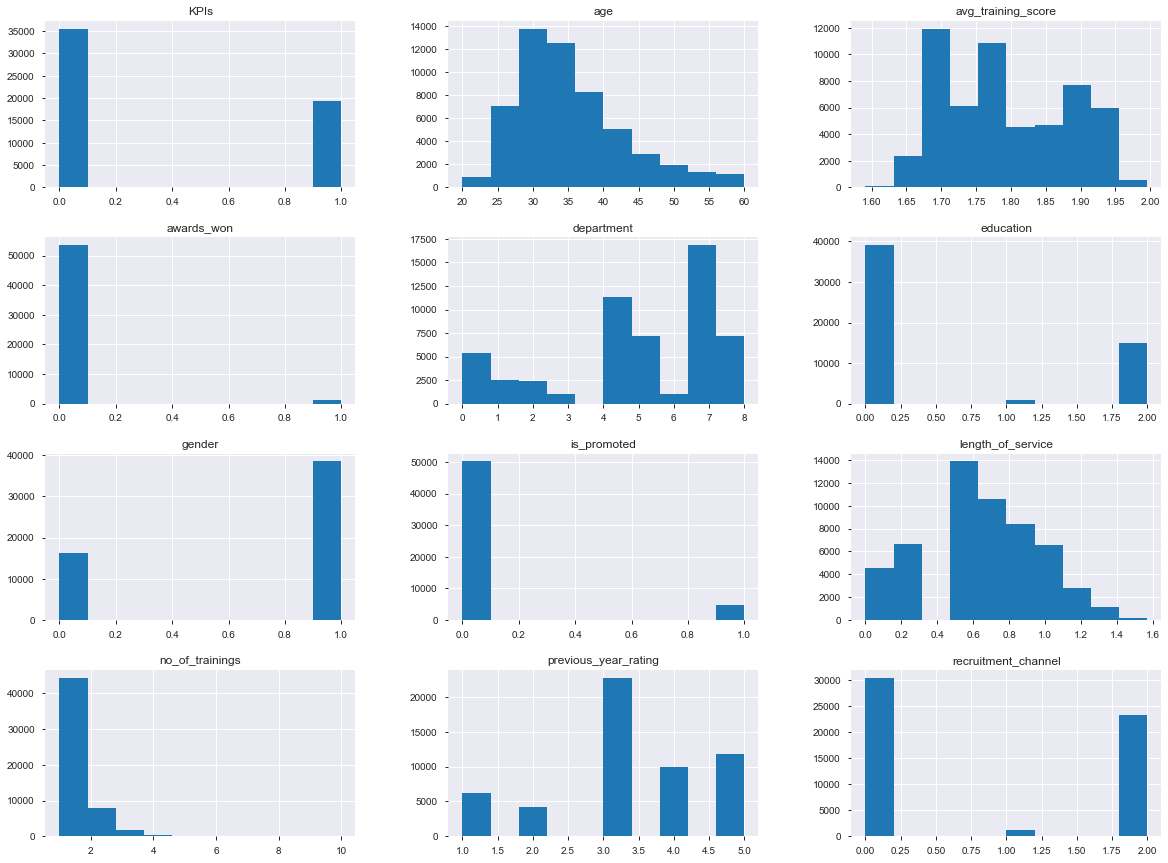

In [27]:
# Histogram Visualtion of the Data

df.hist(bins=10, figsize=(20,15))
plt.show()

In [28]:
# Merge the Data Test Data
test = pd.concat([num_test,cat_test],axis=1)

In [29]:
# find the number of prom samples so we can down sample our majority to it
yes_prom = len(df[df['is_promoted'] ==1])

# retrieve the indices of the non-prom and prom samples 
yes_prom_ind = df[df['is_promoted'] == 1].index
no_prom_ind = df[df['is_promoted'] == 0].index

# random sample the non-prom indices based on the amount of 
# promulent samples
new_no_prom_ind = np.random.choice(no_prom_ind, yes_prom, \
replace = False)

# merge the two indices together
undersample_ind = np.concatenate([new_no_prom_ind, yes_prom_ind])

# get undersampled dataframe from the merged indices
undersampled_data = df.loc[undersample_ind]

In [30]:
# divide undersampled_data into features and is_promoted label

X = undersampled_data.loc[:, undersampled_data.columns != 'is_promoted']
y = undersampled_data.loc[:, undersampled_data.columns == 'is_promoted']


In [31]:
# Split the Data into Train and Test 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [32]:
# Import Random Forest and Logistic Regression Models

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

### Logistic Regression 

In [33]:
# Logistic Regression 

lr = LogisticRegression()

lr.fit(X_train, y_train)

lr_Pred=lr.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, lr_Pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1406
           1       0.72      0.73      0.73      1395

    accuracy                           0.73      2801
   macro avg       0.73      0.73      0.73      2801
weighted avg       0.73      0.73      0.73      2801



Text(0.5, 257.44, 'Predicted label')

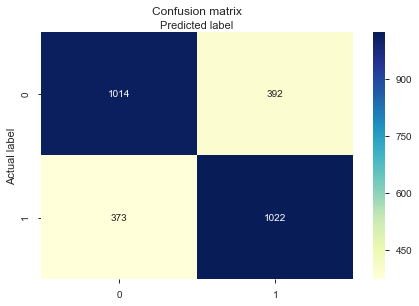

In [34]:
#Confusion Matrix
cnf_matrix=metrics.confusion_matrix(y_test, lr_Pred)
cnf_matrix

#Visualize confusion matrix using heat map

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Random Forest Models

In [35]:
# Fir Random Forest Model

rf = RandomForestClassifier(n_estimators = 1000)

rf.fit(X_train, y_train)

rf_Pred=rf.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, rf_Pred))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1406
           1       0.76      0.84      0.80      1395

    accuracy                           0.79      2801
   macro avg       0.79      0.79      0.79      2801
weighted avg       0.79      0.79      0.79      2801



Text(0.5, 257.44, 'Predicted label')

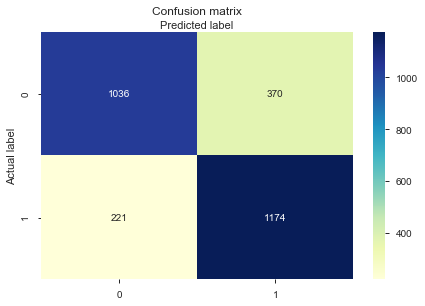

In [36]:
#Confusion Matrix
cnf_matrix=metrics.confusion_matrix(y_test, rf_Pred)
cnf_matrix
#Visualize confusion matrix using heat map

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [37]:
# Data types of the Test Data for Feature Selection
test.columns

Index(['employee_id', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs', 'awards_won', 'avg_training_score',
       'department', 'education', 'gender', 'recruitment_channel'],
      dtype='object')

In [38]:
#Select feature column names and target variable we are going to use for Prediction
features = ['no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs', 'awards_won', 'avg_training_score',
       'department', 'education', 'gender', 'recruitment_channel']

target = 'is_promoted'

test[features].head(3)

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs,awards_won,avg_training_score,department,education,gender,recruitment_channel
0,1,24,3.0,0.00000,1,0,1.886491,8,0,1,2
1,1,31,3.0,0.69897,0,0,1.707570,2,0,0,0
2,1,31,1.0,0.60206,0,0,1.672098,7,0,1,0


In [39]:
#Make predictions using Bangging Classifier
pred_lr = lr.predict(test[features])

#Make predictions using KNN
pred_rf = rf.predict(test[features])

In [40]:
#Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not

submission1 = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':pred_lr})

submission2 = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':pred_rf})

In [41]:
#Convert DataFrame to a csv file that can be uploaded

print(submission1.to_csv('Predictions/Pred_lr.csv',index=False))

print(submission2.to_csv('Predictions/Pred_rf.csv',index=False))

None
None


**K-Fold Cross Validation with Random Forest**

In [42]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

crf = RandomForestClassifier(n_estimators=1000)

scoring = 'accuracy'

accuracy = cross_val_score(crf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)

print(accuracy)

[0.79204893 0.77828746 0.76299694 0.78899083 0.78899083 0.78254211
 0.78407351 0.81163859 0.8101072  0.80398162]


In [43]:
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",round(accuracy.mean() * 100,2))

Accuracy of Model with Cross Validation is: 79.04
